# DengAI
This project comes from the challenge proposed by [DRIVENDATA](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/). The goal consists of predicting how many dengue fever cases occur in two different cities. In order to do so, they provide a set of standard features that include aspects such as temperature, level of vegetation, etc.

It is important to state that since our intention is to predict the number of cases this is a regression problem. However, if we quantize the ```y``` labels we might also consider a classification problem, although we leave such task for another analysis.

## Reading data

In [1]:
import pandas as pd
import os
import numpy as np

def read_data(data_file):
    data_structure = pd.read_csv(os.path.join('data',data_file))
    return data_structure

features = read_data('dengue_features_train.csv');
labels = read_data('dengue_labels_train.csv');
print('Training data readed!')

# We mix features and labels in a single dataset for commodity
features['total_cases']=labels['total_cases']
# Number of cities
print('Cities: {}'.format(features.city.unique()))


Training data readed!
Cities: ['sj' 'iq']


In order to grasp the dataset we focus on one of the cities. Then, we can replicate our analyses with the other one.

In [2]:
# We split data for the two cities
#city_data = features[features['city'] == 'sj']
city_data = features[features['city'] == 'iq']


# Data imputation
We check out how many of the features are missing (NaN) columnwise. It is important to appoint such values, since models might be affected by those points.

In [3]:
missing = {}
for col in city_data:
    missing_no = city_data[col].isna().sum()
    if missing_no != 0:
        missing[col] = missing_no;

pd.DataFrame(missing.values(), index = missing.keys(), columns=['Number of missing elements'])

,Number of missing elements
ndvi_ne,3
ndvi_nw,3
ndvi_se,3
ndvi_sw,3
precipitation_amt_mm,4
reanalysis_air_temp_k,4
reanalysis_avg_temp_k,4
reanalysis_dew_point_temp_k,4
reanalysis_max_air_temp_k,4
reanalysis_min_air_temp_k,4


We observe that some of these could be estimated using alternative features. That is hte example of "station_avg_temp_c", which could be estimated using "station_max_temp_c" and "station_min_temp_c" if they existed. Same could happen with "reanalysis_avg_temp_k". 

Nevertheless, since we are working with temporal series data it seems reasonable enough to interpolate the missing values using the data that we already know. This might be effective if the missing values are sparsely distributed.

In [4]:
for col in missing.keys():
    city_data[col].interpolate(inplace=True)

/home/osthaton/anaconda3/envs/deep/lib/python3.7/site-packages/pandas/core/generic.py:7070: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


# New features

We infer some features that might be interesting: 
* ```day``` 
* ```month``` 

using ```week_start_date```. We remove the latter, and also ```city``` since we will perform our regression considering each city separatedly.



In [9]:
city_data['month'] = city_data.apply(lambda x: int(x['week_start_date'][5:7]), axis=1);
city_data['day'] = city_data.apply(lambda x: int(x['week_start_date'][8:10]), axis=1);
city_data.pop('week_start_date');
city_data.pop('city');

# city_data['inverse_year'] = city_data['year'].apply(lambda x: 1/x);


KeyError: ('week_start_date', 'occurred at index 936')

We include a feature that might be interesting, which is the ```season```. Considering that there are four seasons (spring, summer, autumn, winter), we provide a numerical label for each one of them. The underlying idea is that depending on the month, we will code a new feature indicating the season under analysis. This is clearly a periodic feature, which is potentially relatable with the number ```total_cases```.

![Image](https://images.theconversation.com/files/253677/original/file-20190114-43517-11n11cr.jpg?ixlib=rb-1.1.0&rect=149%2C4%2C2318%2C1580&q=45&auto=format&w=496&fit=clip)

In [6]:
# We define the four seasons from the North hemishpere. 
def season(input_data):
    input_data = int(input_data)
    if (input_data >=1) & (input_data <=3): # Winter        
        output = 4;        
    if (input_data >=4) & (input_data <=6): # Spring        
        output = 1;
    if (input_data >=7) & (input_data <=9): # Summer        
        output = 2;
    if (input_data >=10) & (input_data <=12): # Autumn/Fall        
        output = 3;
    return output

city_data['season'] = city_data['month'].apply(season);



/home/osthaton/anaconda3/envs/deep/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/osthaton/anaconda3/envs/deep/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


We also design a function that allows us to include a certain context. That is, our features would be formed not only by current data (in a certain time ```t```), but also by previous values (```t-1```, ```t-2```, etc.). However, we don't make extensive use of this function for now.

In [7]:
def context_extractor(data_structure):
    alt_data_structure = data_structure[:];
    
    col_names = [i for i in data_structure.columns  if i not in ['total_cases','total_cases_LOG','diff','pos_neg']]
    lag = 1;
    col_names_lag = [i+'_'+str(lag) for i in col_names]
    
    alt_data_structure[col_names_lag] = city_data[col_names]
    alt_data_structure['weekofyear_1'] = alt_data_structure['weekofyear_1'].shift(1)
#     for i in range(len(data_structure)):
#         if i > 0:
#             print(alt_data_structure['weekofyear_1'].iloc[i], city_data['weekofyear'].iloc[i-1])
#             alt_data_structure[col_names_lag].iloc[i] = city_data[col_names].iloc[i-1].values
#             print(alt_data_structure['weekofyear_1'].iloc[i], city_data['weekofyear'].iloc[i-1])
#             break
            
    return alt_data_structure
# city_data= context_extractor(city_data)
# city_data.fillna(0, inplace=True)

# Studying correlation
It is quite important to understand what is the correlation between our existing features. An interesting fact is that correlation allows to measure some degree of similarity in a linear way, which means that two features that show a big value of such score can be linearly obtained from each other. This means that using features with a significant degree of correlation might worsen the performance of a model, since we would be feeding it using data that is redundant. Consequently, we need to minimize the number of features that are strongly correlated.

On the contrary, features that are highly correlated with the labels, denoted ```total_cases```, are highly desirable since they can be helpful to make our predictions.

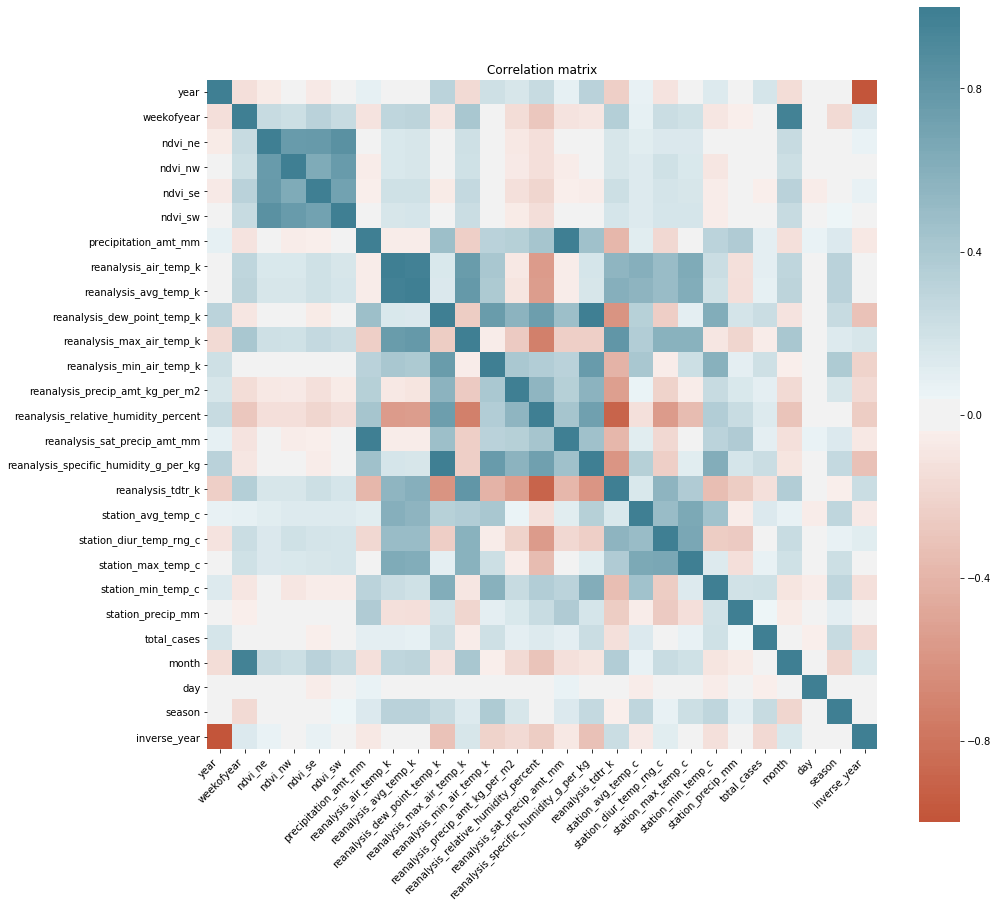

In [8]:
# We study each feature independently and how it relates with the rest
from DengAI_utils import compute_correlation
correlation_matrix = compute_correlation(city_data);

We can observe that some of the features are strongly correlated, as it happens with ```ndvi_``` features and ```reanalysis_air_temp_k``` and ```reanalysis_avg_temp_k```.

If we focus on the correlation between ```total_cases``` and our feature-set we obtain the following graph, which depicts that for the ```city=iq``` the top features are ```season```, a humidity variable and three temperature variables. Notice that these will change for ```city=sj```.

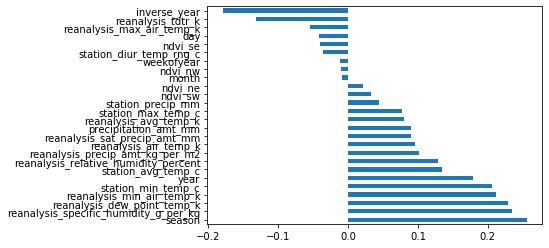

In [13]:
correlation_matrix.total_cases.drop('total_cases').sort_values(ascending=False).plot.barh();

We can get a ranking with such scores and use it later to train our model.

In [14]:
sorted_features = correlation_matrix.total_cases.drop('total_cases').sort_values(ascending=False)
sorted_features[:7]

season                                   0.256320
reanalysis_specific_humidity_g_per_kg    0.235218
reanalysis_dew_point_temp_k              0.229183
reanalysis_min_air_temp_k                0.211679
station_min_temp_c                       0.206817
year                                     0.179451
station_avg_temp_c                       0.133989
Name: total_cases, dtype: float64

# TSNE

In [11]:
# from sklearn.manifold import TSNE
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler();
# cd_scaled = scaler.fit_transform(city_data[[i for i in city_data.columns if i not in 'total_cases']])
# tsne_list = {}
# for i_list in range(1):
    
#     tsne_seed = np.random.randint(1e5) 
#     tsne_seed = 42895;
    
#     # 22847 (0.29660216737477874, tsne0, 2c)
#     tsner = TSNE(n_components=2, random_state=tsne_seed)
#     cd_tsned = tsner.fit_transform(cd_scaled)

#     for i in range(cd_tsned.shape[1]):
#         city_data['tsne_{}'.format(i)] = cd_tsned[:,i]
#     # We study each feature independently and how it relates with the rest
#     correlation_matrix = city_data.corr()

#     (correlation_matrix
#          .total_cases
#          .drop('total_cases') # don't compare with myself
#          .sort_values(ascending=False)
#     )
    
#     config = {}
#     config['seed'] = tsne_seed;
#     config['tsne_0'] = (correlation_matrix
#          .total_cases
#          .drop('total_cases'))['tsne_0']
#     config['tsne_1'] = (correlation_matrix
#          .total_cases
#          .drop('total_cases'))['tsne_1']
#     tsne_list[i_list] = config
    
# tsne_0_vec = [np.abs(i['tsne_0']) for i in tsne_list.values()];
# tsne_1_vec = [np.abs(i['tsne_1']) for i in tsne_list.values()];

# print('Max 0: {}. Seed: {}'.format(np.max(tsne_0_vec),tsne_list[np.argmax(tsne_0_vec)]['seed']))
# print('Max 1: {}. Seed: {}'.format(np.max(tsne_1_vec),tsne_list[np.argmax(tsne_1_vec)]['seed']))

In [12]:
# tsne_0_vec = [np.abs(i['tsne_0']) for i in tsne_list.values()];
# tsne_1_vec = [np.abs(i['tsne_1']) for i in tsne_list.values()];

# print('Max 0: {}. Seed: {}'.format(np.max(tsne_0_vec),tsne_list[np.argmax(tsne_0_vec)]['seed']))
# print('Max 1: {}. Seed: {}'.format(np.max(tsne_1_vec),tsne_list[np.argmax(tsne_1_vec)]['seed']))

# Poly features
Alternative features can be computed using polynomic functions. We select some of the features and attempt to extract a new set using their polynomic combinations.

In [52]:
selected_features = ['weekofyear','month','inverse_year','reanalysis_specific_humidity_g_per_kg','reanalysis_dew_point_temp_k','station_avg_temp_c','reanalysis_max_air_temp_k']
from ML_utils.FeatureExtraction import FeatureExtraction
feature_extractor = FeatureExtraction();
feature_extractor.polynomial(9);
feature_extractor.fit(city_data[[i for i in city_data.columns if i in selected_features]])
poly_feat = pd.DataFrame(feature_extractor.transform(city_data[[i for i in city_data.columns if i in selected_features]], 'poly'))

poly_feat['total_cases'] = city_data['total_cases']
sorted_features = (poly_feat.corr()
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False))
poly_selection = sorted_features[:1].keys()

In [53]:
n_poly = 1;
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
aux = scaler.fit_transform( poly_feat[sorted_features[:n_poly].keys()])

for i in range(n_poly):
    city_data['poly_{}'.format(i)] = aux[:,i]

/run/media/arodriguez/BIG/anaconda2/envs/deep_py3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In the city we are analysing, it seems that ```poly_0``` is working reasonably well. Notice that such polynomia was computed after studying different combinations until the 9th degree.

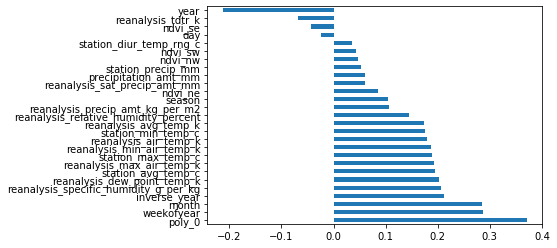

In [55]:
# This interesting
(correlation_matrix
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh())

In [1]:
# This interesting
n_features = 10;
top_features = (correlation_matrix
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False))[0:n_features]
top_features.keys()

NameError: name 'correlation_matrix' is not defined

# Neural networks

# LSTM


In [20]:
def return_batch(x_train_data, y_train_data, batch_size=5, seq_length=10):
#     x_batch = np.zeros([batch_size, seq_length, x_train_data.shape[1]]);
#     y_batch = np.zeros([batch_size, 1]);
    
    while True:
        n_batches = int(np.ceil(len(x_train_data)/batch_size));
#         for i_batch in range(n_batches):
        x_batch = []
        y_batch =[]
        c = 0;
        for i in range(len(x_train_data)-seq_length-10):
#             x_batch[c, :,:] = np.expand_dims(x_train_data[i:i+seq_length,:]*1.0, axis=0)
#             y_batch[c,:] = np.expand_dims(y_train[i+seq_length-1]*1.0, axis=0)
            
            x_batch.append(np.expand_dims(x_train_data[i:i+seq_length,:]*1.0,axis=0))
            if len(y_train.shape) == 2:                
                y_batch.append(np.expand_dims(y_train_data.iloc[i+seq_length-1,:].values*1.0, axis=0))
                
            else:
                y_batch.append(np.expand_dims(y_train_data.values[i+seq_length-1]*1.0, axis=0))
                
            c+=1;
            if c%batch_size==0:
                c=0;
                yield np.concatenate(x_batch,axis=0), np.concatenate(y_batch,axis=0)
            
        yield np.concatenate(x_batch,axis=0), np.concatenate(y_batch,axis=0)
                        
# aux, aux2 = return_batch(x_train_set,y_train_set, len(x_train_set))
# aux, aux2 = return_batch(x_val_set, y_val_set,len(x_val_set), l_sequence)



In [ ]:
# Regression
y_train = city_data['total_cases']
from sklearn.model_selection import TimeSeriesSplit

from keras.layers import LSTM, Dense
from keras import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

# x_train = city_data[[col for col in city_data.columns if col not in ['total_cases','total_cases_LOG']]]
# y_train = city_data['total_cases']
x_train['spikes']=model_spikes.predict(x_train);
x_test['spikes']=model_spikes.predict(x_test);
x_train['ridge']=model.predict(x_train);
x_test['ridge']=model.predict(x_test);
x_train['ridge_exp']=np.exp(model.predict(x_train));
x_test['ridge_exp']=np.exp(model.predict(x_test));
x_train['bayes']=model_Bayes.predict(x_train);
x_test['bayes']=model_Bayes.predict(x_test);


batch_size = 20;
l_sequence = 50;
n_lstm =  20;
# np.random.seed(15)
x_in = Input(shape=[l_sequence, x_train.shape[1]])
x = LSTM(n_lstm,return_sequences=False, stateful=False)(x_in)
# x = LSTM(1,return_sequences=False, stateful=False)(x)
x = Dense(1,activation='relu')(x)



# model.compile(optimizer='Adam', loss='mae')
opt = Adam(lr=0.01)
model_index = 0;
storage_model = {};

splitter = TimeSeriesSplit(n_splits = 2)
for train_index, val_index in splitter.split(x_train):
#     x_train_set, x_val_set = x_train.iloc[train_index], x_train.iloc[val_index]
#     y_train_set, y_val_set = y_train[train_index], y_train[val_index]
#     print(x_train_set.shape, x_val_set.shape)
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
#     x_train_set = scaler.fit_transform(x_train_set)
#     x_val_set = scaler.transform(x_val_set)
    x_train_set = scaler.fit_transform(x_train)
    x_val_set = scaler.transform(x_test)
    y_train_set = y_train;
    y_val_set = y_test;
    
    model_LSTM = Model(inputs = x_in, outputs = x)
#     model.summary()
    model_LSTM.compile(optimizer=opt, loss='mae')
    checkpoint = ModelCheckpoint('models/LSTM_{}'.format(model_index),save_best_only=True)
    h = model_LSTM.fit_generator(return_batch(x_train_set, y_train_set, batch_size,l_sequence),
                        steps_per_epoch = np.round(len(x_train_set)/batch_size),
                        epochs = 300,        
                        verbose=0,
                        validation_data=return_batch(x_val_set, y_val_set,batch_size, l_sequence),
                        validation_steps=np.round(len(x_val_set)/batch_size),
                        callbacks = [checkpoint]
                       )
    aux = {}
    aux['history'] = h;
#     aux['model'] = model;

    #model.save('models/LSTM_{}'.format(model_index))
    aux['scaler'] = scaler
    
    storage_model['model_{}'.format(model_index)] = aux;
    model_index+=1;
    del model_LSTM
#     plt.plot(h.history['loss'], label='train')
#     plt.plot(h.history['val_loss'], label='val')
#     plt.legend()
    break
    

Using TensorFlow backend.


18.71179541321688


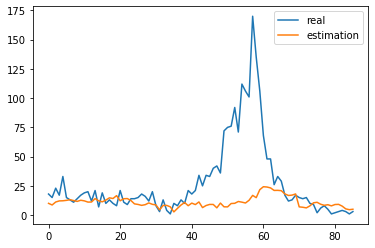

In [43]:
from keras.models import  load_model
for ind_model in range(len(storage_model)):
    model_LSTM = load_model('models/LSTM_{}'.format(ind_model))

    predictions  = []
    real_outputs = []
#     for i in range(len(x_val_set)-l_sequence):
#         predictions.append(np.exp(np.squeeze(model_LSTM.predict(np.expand_dims(x_val_set[i:i+l_sequence,:], axis=0)))));
#         real_outputs.append(np.exp(y_val_set.iloc[i+l_sequence-1]));
    for i in range(len(x_test)-l_sequence):
        #predictions.append((np.squeeze(model_LSTM.predict(np.expand_dims(x_test.iloc[i:i+l_sequence,:], axis=0)))));
        predictions.append((np.squeeze(model_LSTM.predict(np.expand_dims(x_val_set[i:i+l_sequence,:], axis=0)))));
        real_outputs.append((y_test.iloc[i+l_sequence-1]));

    plt.plot(real_outputs, label='real');
    plt.plot(predictions, label='estimation')
    plt.legend()


    from sklearn.metrics import mean_absolute_error
    print(mean_absolute_error(real_outputs, predictions))

{'alpha_1': 1e-09, 'alpha_2': 0.1, 'lambda_1': 0.1, 'lambda_2': 1e-09}
-45.81203231543013


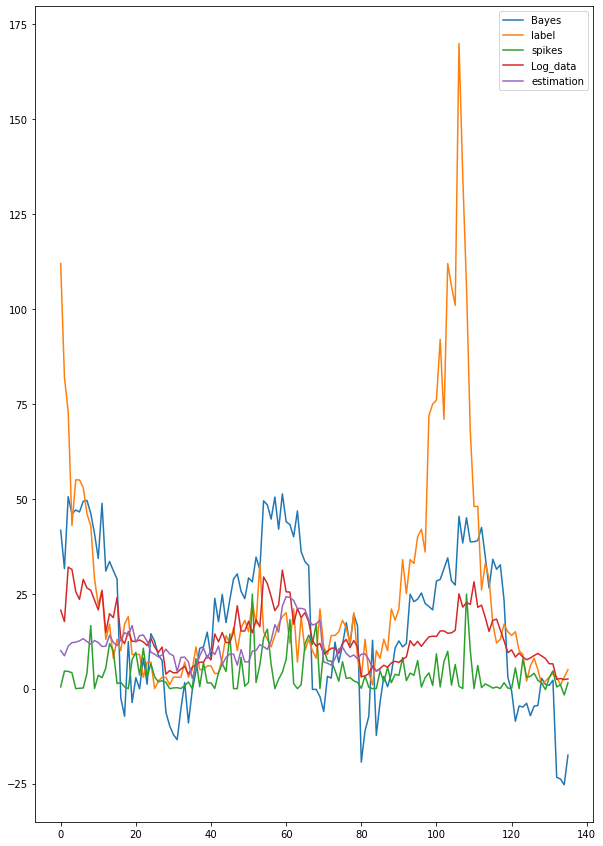

In [46]:
plt.figure(figsize=(10,15))
# plt.subplot(211)
# plt.plot(model_Bayes.best_estimator_.predict(x_train[[i for i in x_train.columns if i != 'extra_data']]),label='Bayes')
# plt.plot(y_train,label='label')
# plt.plot(model_spikes.best_estimator_.predict(x_train[[i for i in x_train.columns if i != 'extra_data']]),label='spikes')
# plt.plot(np.exp(model.best_estimator_.predict(x_train[[i for i in x_train.columns if i != 'extra_data']])), label='Log_data')
# plt.legend()

# plt.subplot(212)
plt.plot(model_Bayes.best_estimator_.predict(x_test[[i for i in x_test.columns if i != 'extra_data']]),label='Bayes')
plt.plot(y_test.values,label='label')
plt.plot(model_spikes.best_estimator_.predict(x_test[[i for i in x_test.columns if i != 'extra_data']]),label='spikes')
plt.plot(np.exp(model.best_estimator_.predict(x_test[[i for i in x_test.columns if i != 'extra_data']])), label='Log_data')
plt.plot(predictions, label='estimation')
plt.legend()
print(model_Bayes.best_params_)
print(model_Bayes.best_score_)

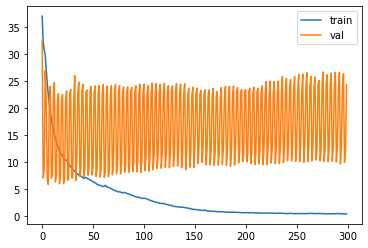

In [38]:
# n_lstm = 5
for n_model in range(len(storage_model)):
    plt.subplot(len(storage_model), 1, n_model+1)
    plt.plot(storage_model['model_{}'.format(n_model)]['history'].history['loss'], label='train')
    plt.plot(storage_model['model_{}'.format(n_model)]['history'].history['val_loss'], label='val')
    plt.legend()

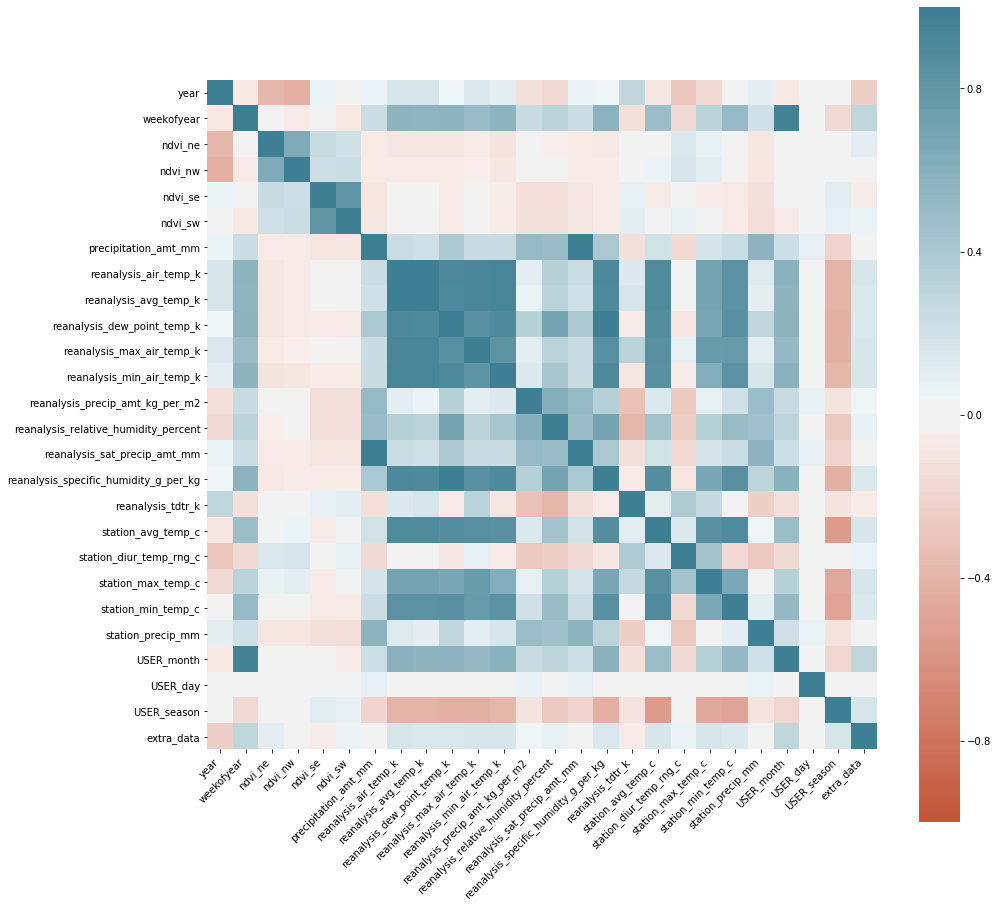

In [39]:
# We study each feature independently and how it relates with the rest
correlation = x_train.corr()
import seaborn as sns
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(15,15)) 
ax = sns.heatmap(
    correlation, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [ ]:
# # Classifier
# y_train = pd.get_dummies(city_data['total_cases_LOG'],prefix=['label'])

# from sklearn.model_selection import TimeSeriesSplit

# from keras.layers import LSTM, Dense
# from keras import Input
# from keras.models import Model
# from keras.optimizers import Adam

# batch_size = 20;
# l_sequence = 20
# n_lstm = 5;
# # np.random.seed(15)
# x_in = Input(shape=[l_sequence, x_train.shape[1]])
# x = LSTM(n_lstm,return_sequences=False, stateful=False)(x_in)
# # x = LSTM(1,return_sequences=False, stateful=False)(x)
# x = Dense(7,activation='sigmoid')(x)



# # model.compile(optimizer='Adam', loss='mae')
# opt = Adam(lr=0.01)
# model_index = 0;
# storage_model = {};

# splitter = TimeSeriesSplit(n_splits = 5)
# for train_index, val_index in splitter.split(x_train):
#     x_train_set, x_val_set = x_train.iloc[train_index], x_train.iloc[val_index]
#     y_train_set, y_val_set = y_train.iloc[train_index], y_train.iloc[val_index]
    
#     from sklearn.preprocessing import StandardScaler
#     scaler = StandardScaler()
#     x_train_set = scaler.fit_transform(x_train_set)
#     x_val_set = scaler.transform(x_val_set)
    
#     model = Model(inputs = x_in, outputs = x)
#     model.summary()
#     model.compile(optimizer=opt, loss='binary_crossentropy')
#     h = model.fit_generator(return_batch(x_train_set, y_train_set, batch_size,l_sequence),
#                         steps_per_epoch = np.round(len(x_train_set)/batch_size),
#                         epochs = 50,        
#                         verbose=0,
# #                         validation_data=return_batch(x_val_set, y_val_set,batch_size, l_sequence),
# #                         validation_steps=np.round(len(x_val_set)/batch_size)
#                        )
#     aux = {}
#     aux['history'] = h;
#     aux['model'] = model;
#     aux['scaler'] = scaler
    
#     storage_model['model_{}'.format(model_index)] = aux;
#     model_index+=1;
#     del model
# #     plt.plot(h.history['loss'], label='train')
# #     plt.plot(h.history['val_loss'], label='val')
# #     plt.legend()
# #     break
    

In [ ]:
# # n_lstm = 5
# for n_model in range(len(storage_model)):
#     plt.subplot(len(storage_model), 1, n_model+1)
#     plt.plot(storage_model['model_{}'.format(n_model)]['history'].history['loss'], label='train')
#     plt.plot(storage_model['model_{}'.format(n_model)]['history'].history['val_loss'], label='val')
#     plt.legend()

In [ ]:
# from sklearn.metrics import mean_absolute_error
# predictions = []
# real_outputs = []
# for i in val_index:
#     #mean_absolute_error(y_train[np.arange(val_index[0]-batch_size+1,val_index[0]+1)],np.squeeze(model.predict(np.expand_dims(x_train.iloc[np.arange(val_index[0]-batch_size+1,val_index[0]+1)],axis=0))))
# #     print(x_train.iloc[np.arange(i-batch_size+1,i+1)]['year'])

#     y_pred = np.squeeze(model.predict(np.expand_dims(x_train[np.arange(i-batch_size+1,i+1)],axis=0)));
# #     y_pred = np.squeeze(model.predict(np.expand_dims(x_train.iloc[np.arange(i-batch_size+1,i+1)],axis=0)));
#     y_true = y_train[i];
# #     print(y_true)
#     real_outputs.append(y_true)
#     predictions.append(y_pred)
#     print(y_pred, y_true)

# plt.plot(real_outputs, label='real');
# plt.plot(predictions, label='estimation')
# plt.legend()


In [ ]:
# from sklearn.model_selection import TimeSeriesSplit
# splitter = TimeSeriesSplit(n_splits = 2)
# n_train = 300;
# x_train_set, x_val_set = x_train.iloc[:n_train], x_train.iloc[n_train-batch_size+1:n_train+1]
# y_train_set, y_val_set = y_train[:n_train], y_train[n_train-batch_size+1:n_train+1]




# opt = Adam(lr = 0.1);

# batch_size = 2;
# x_in = Input(shape=[batch_size, x_train.shape[1]],batch_shape = [1,batch_size, x_train.shape[1]])
# x = LSTM(batch_size,return_sequences=True, stateful=True)(x_in)
# x = LSTM(batch_size,return_sequences=False, stateful=True)(x)

# model = Model(inputs = x_in, outputs = x)
# model.compile(optimizer=opt, loss='mae')
# model.fit_generator(return_batch(x_train_set, y_train_set, batch_size),
#                     steps_per_epoch = np.round(len(x_train_set)/batch_size),
#                     epochs = 5)


In [ ]:
# y_pred = model.predict(np.expand_dims(x_val_set,axis=0))
# mean_absolute_error(y_val_set, np.squeeze(y_pred))

# # model.summary()

# Data scaling

In [ ]:
# from Classifiers import classifiers


In [ ]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# aux = scaler.fit_transform(x_train)

In [ ]:
# # Cross-validation
# from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
# import random
# from sklearn.model_selection import RandomizedSearchCV
# n_iter_search = 1000

# clf_list = ['rforest']
# #['knn','SVM_linear','rforest','gboost','SVM','logistic_regression','MLP','adaboost']

# output_classifier = {}
# output_score = {}
# for clf_name in clf_list: 
#     model, param_dist = classifiers(clf_name,1492,n_iter_search)

#     clf = RandomizedSearchCV(model, param_dist, n_iter=10, 
#                        scoring='neg_mean_absolute_error', 
#                              n_jobs=-1, cv=5, verbose=1, random_state=1492)

#     clf.fit(x_train, y_train)
#     output_classifier[clf_name] = clf.best_estimator_
#     output_score[clf_name] = clf.best_score_

In [ ]:
# y_pred = clf.best_estimator_.predict(x_val)

# from sklearn.metrics import mean_absolute_error
# mean_absolute_error(y_val, y_pred)
